# CM50270 Reinforcement Learning
## Graded Assessment 1: Racetrack

In this assignment, you will compare the performance of three reinforcement learning algorithms - *On-Policy First-Visit Monte Carlo Control*, *Sarsa*, and *Q-Learning* - in a simple racetrack environment. You will then implement a modified TD agent that improves upon the learning performance of a basic Q-Learning agent.

**Date Set:** 3rd March 2025

**Date Due:** 17th March 2025 (20:00)

**Total Number of Marks:** 30 Marks

**Contribution to Unit Grade:** 30%

**What to submit:** Your completed Jupyter notebook (.ipynb file) which should include **all** of your source code. Please **do not change the file name or compress/zip your submission**.

**Where to submit:** CM50270 Moodle Page.

This coursework will be marked **anonymously**. Please do not include any identifying information on the files you submit.

You are required to **work individually** on this coursework. You are welcome to discuss ideas with others but you must design your own implementation and **write your own code and answers**. If you do include any any third-party code or text in your submission, please **reference it appropriately**.

**Do not plagiarise**. Plagiarism is a serious academic offence. Both your code and written answers will be automatically checked for possible instances of plagiarism. For details on what plagiarism is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

**The is a Type A assessment**. Please do not use generative artificial intelligence ("GenAI") tools to create any part of your submission. For details on the University of Bath's policy towards the use of generative artificial intelligence in teaching and assessment, please visit the following webpage: https://www.bath.ac.uk/announcements/academic-integrity-in-the-generative-artificial-intelligence-genai-context/.

If you are asked to use specific variable names, data-types, function signatures and notebook cells, please **ensure that you follow these instructions**. Not doing so will cause our marking software to reject your work. Please **do not delete, duplicate, or replace existing cells**: if you need additional cells, please insert new ones. **If our marking software rejects your work because you have not followed the instructions given, you may not get any credit for your work**.

For this coursework, you may use the [Python standard library](https://docs.python.org/3/library/), numpy, and matplotlib. You should also use the `racetrack_env.py` file, which we have provided for you. Please **do not use any other non-standard, third-party libraries**. **If we are unable to run your code because you have used unsupported external libraries, you may not get any credit for your work.**

Please **ensure that your code is readable**. If we cannot tell what your code is doing when marking, you may not get full credit for your work.

Please remember to **save and backup your work regularly**.

Please be sure to **restart the kernel and run your code from start-to-finish** (Kernel → Restart & Run All) before submitting your notebook.<br>Otherwise, you may not be aware that you are using variables in memory that you have deleted, causing your code to fail when we try to run it later.

**Your total runtime must be less than 10 minutes** on the University's lab computers. If your submission exceeds this, it will be automatically interrupted, and you may not get full credit for your work.

Please **adhere to written answer length limits**. When marking, we will not read beyond the specified maximum word counts, and you may not get any credit for anything written beyond them.

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of coursework. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods. It is worth noting that tuples can be used to index certain Python data-structures, such as dictionaries.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


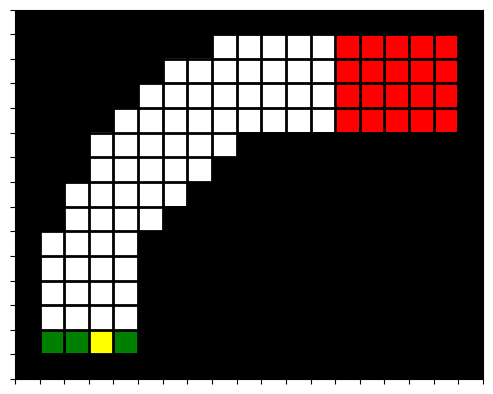

Initial State: (1, 3, 0, 0)


In [1]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

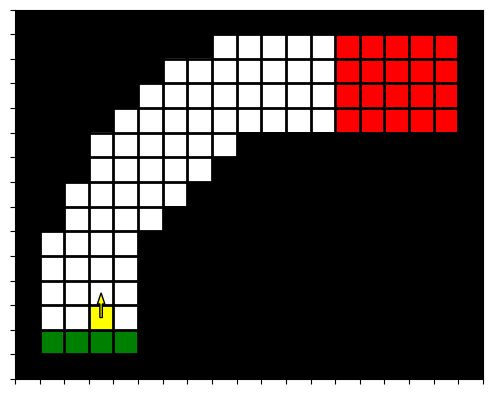

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [2]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

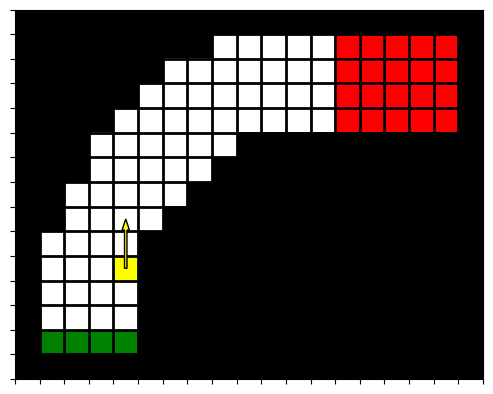

In [3]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise 1: Comparing Fundamental RL Algorithms (12 Marks)

Below, we have plotted learning curves showing the performance of On-Policy Monte Carlo Control, Sarsa, and Q-Learning in the Racetrack environment.
We have included an unaltered version of the learning curve, as well as a cropped version to make it easier to compare agents' performance towards the end of training.

For reference, the agents were trained using the following parameters:
- Exploration rate $\epsilon = 0.15$.
- Discount factor $\gamma = 0.9$.
- Intial action-value estimates $Q_0 = 0.0$.
- Learning rate $\alpha = 0.2$ (for Sarsa and Q-Learning).

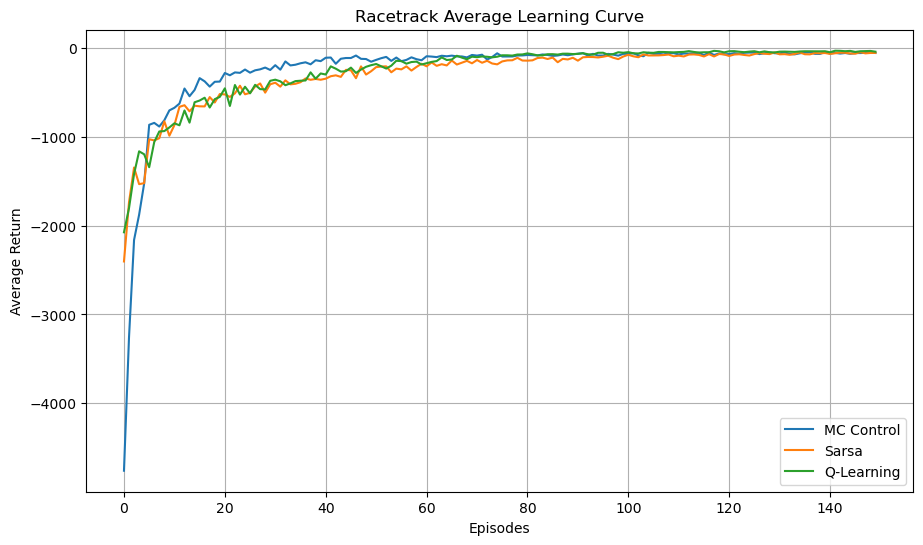

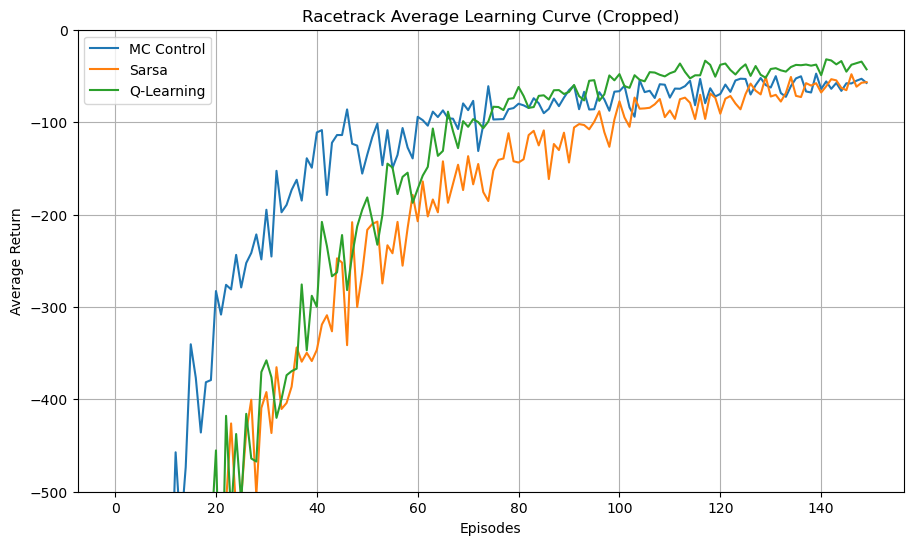

In [4]:
from racetrack_env import plot_combined_results

# Plotting Combined Learning Curve.
%matplotlib inline
plot_combined_results()

Based on these results, and your understanding of the three algorithms used to produce them, please answer the following discussion questions. <br />

**Question 1:** Briefly compare the performance of each of the three agents.

**Question 2:** Why do you think that the Monte Carlo and Temporal-Difference agents behaved differently?

**Question 3:** Does the performance of the Sarsa and Q-Learning agents meet your expectations? Why do you think that this is the case?

**Question 4:** What could be done to improve the performance of these agents?

Please do not exceed **70 words** for any of your answers.

Please write your answers for Exercise 1 in this markdown cell.

**Answer 1:**

Early SARSA and Q-learning performances are similar. MC control performs worse early because it needs complete episodes to update Q-Tables, leading to larger exploration. Performing best between episodes 10-75, exploiting exploration. Conservative exploration causes SARSA and Q-Learning to perform worse. After 75 episodes, Q-Learning performs best; it learns Off-Policy actions. The others learn optimal On-Policy actions. SARSA performs worst, exploring less than MC and not learning Off-Policy like Q-Learning.

**Answer 2:**

MC agents (MCA) update at the end of episodes; TD agents (TDA) during episodes. MCA poorer early training yields greater environment knowledge mid-training than TDA. Off-Policy Q-Learning performs better than On-Policy MCA because optimal policy actions may not be global optimums. Observed is MCA performing worse initially, with larger early training exploration yielding better performance. Off-Policy TDA ends with better performance, while On-Policy TDA and MCA finish with similar returns. 

**Answer 3:**

Agents performed predictably: Q-Learning converged to a higher return. Q-Learning, an Off-Policy TD method, learns optimal actions regardless of policy. SARSA is On-Policy. SARSA agents choose their policies' best next action to update Q-Tables, whereas Q-Learning chooses the largest valued action in the next state. Initially, both algorithms may update Q-Tables with identical values, but Q-Learning then updates this with more globally optimal actions, potentially not in SARSA’s policy.


**Answer 4:**

Three proposed modifications: SARSA(λ), Watkin’s Q(λ) (WQλ) and Epsilon Decay (ED). The first two aim to achieve similar MC agent (MCA) results mid-training while still learning inside episodes, to not experience poor early-training performance. SARSA and Q-Learning updates take longer to backpropogate. SARSA(λ) and WQλ allow earlier state contributions in Q-Table updates, achieving better mid-training results. ED stabilises late training and increases exploitation for MCA and SARSA.

## Exercise 2: Modified Temporal-Difference Learning Agent (18 Marks)
### Exercise 2a: Implementation
In this exercise, you must implement a temporal-difference learning agent that learns to reach a goal state in the racetrack more efficiently than the Q-Learning agent shown above. You may base your implementation on Q-Learning (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131), the pseudocode for which is reproduced below, but you may also base your implementation on Sarsa if you wish.

<img src="images/q_learning_algo.png" style="width: 650px;"/>

In order to score high marks in this exercise, you will need to extend your solution beyond a simple Q-Learning or Sarsa agent to achieve a higher final level of return and/or learn more efficiently (i.e., achieve the same level of return using fewer interactions with the environment).

Some ideas for improving your agent will have been discussed in lectures, and more can be found in the unit textbook (Reinforcement Learning, Sutton & Barto, 2018). You are also welcome to include ideas that you have found elsewhere in your own background reading. However you go about improving your agent, it must still use a **tabular** temporal-difference learning method at its core (i.e., it should **not** make use of function approximation, neural networks etc.).

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** $5$.

**If you use incorrect parameters, you may not get any credit for your work.**

You may adjust all other parameters as you see fit.


Your modified agent code should produce a list named `modified_agent_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `modified_agent_rewards` list will contain $20$ sub-lists, each containing $150$ integers. This list will be used to plot an average learning curve, which will be used to mark your work.


In [5]:
# Please write your code for Exercise 2a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified TD learning agent here.
# Do NOT delete or duplicate this cell.
def sarsa_lambda(eps, l, alp, gam, decay,alpha_decay):
    
    epsilon = eps
    lam = l
    alpha = alp
    gamma = gam
    ad = alpha_decay
    np.random.seed(3)
    Q_table1 = np.random.uniform(0.001, 0, size=(13,12,21,21,9))
    eligibility_table = np.zeros(shape=(13,12,21,21,9), dtype=float)
    agent_reward = []
    episodes = 151

    for e in range(episodes):
        
        if e == 0:
            continue
        else:
            epsilon*=decay
            alpha *= ad
        
        state = env.reset()
        epsilon_greedy1 = np.random.uniform(0,1)
        
        if epsilon_greedy1 > epsilon:
            action_index = np.argmax(Q_table1[state[0]-1,state[1]-1, state[2]+10, state[3]+10])
            action = action_index
        else:
            action = np.random.randint(0,9)
        
        eligibility_table[:,:,:,:,:] = 0
        episode_rewards = 0
        
        while True:
            
            next_stte, r, term  = env.step(action)
            
            epsilon_greedy2 = np.random.uniform(0,1)
            
            if term == True:
                next_Q = 0
                delta = r + gamma * (next_Q - Q_table1[state[0]-1, state[1]-1,state[2]+10,state[3]+10, action])
            else:
                if epsilon_greedy2 > epsilon:
                    next_action = np.argmax(Q_table1[next_stte[0]-1,next_stte[1]-1,next_stte[2]+10, next_stte[3]+10])            
                else:
                    next_action = np.random.randint(0,9)
                delta = r + gamma * (Q_table1[next_stte[0]-1, next_stte[1]-1, next_stte[2]+10, next_stte[3]+10, next_action] - Q_table1[state[0]-1, state[1]-1, state[2]+10, state[3]+10, action])            
            
            eligibility_table[state[0]-1, state[1]-1,state[2]+10,state[3]+10, action] = ((1-alpha)*eligibility_table[state[0]-1, state[1]-1,state[2]+10,state[3]+10, action]) + 1
            
            Q_table1[:,:,:,:,:] += alpha * delta * eligibility_table[:,:,:,:,:]
            eligibility_table[:,:,:,:,:] *= (gamma * lam)
            
            if term==False:
                state = next_stte
                action = next_action
                episode_rewards += r
            else:
                agent_reward.append(episode_rewards)
                break
    
    return agent_reward

d=0.9
epsilo = 0.05
lambd = 0.8
alpha = 0.5
gamma = 0.9
d2 = 0.9


agent1 = sarsa_lambda(epsilo, lambd, alpha, gamma, d, d2)
agent2 = sarsa_lambda(epsilo, lambd, alpha, gamma,d, d2)
agent3 = sarsa_lambda(epsilo, lambd, alpha, gamma,d, d2)
agent4 = sarsa_lambda(epsilo, lambd, alpha, gamma,d, d2)
agent5 = sarsa_lambda(epsilo, lambd, alpha, gamma,d, d2)

modified_agent_rewards = [agent1,agent2,agent3,agent4,agent5]
# YOUR CODE HERE

### Exercise 2b: Comparison & Discussion

Below, we have used your results to plot the performance of your modified agent and a Q-Learning agent on the same set of axes. <br />
A cropped version of this learning curve has also been plotted, to make it easier to compare the performance of your agents towards the end of training. <br />
If you wish, you may plot additional graphs below these learning curves to support the points you make in your discussion.

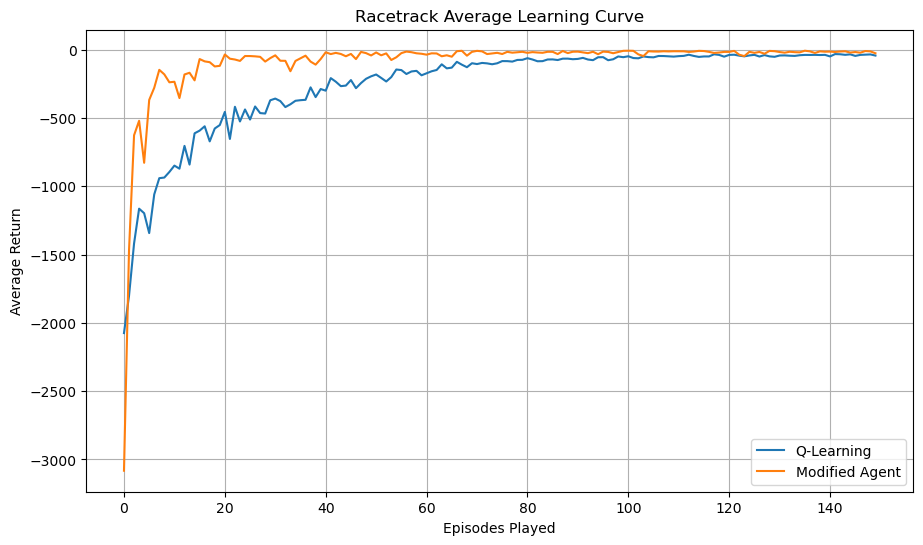

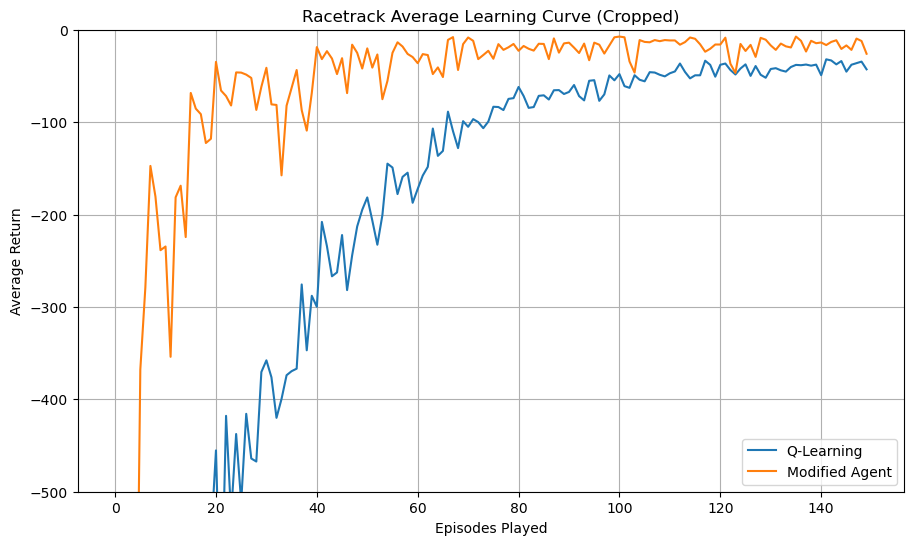

In [6]:
from racetrack_env import plot_modified_agent_results
from racetrack_env import simple_issue_checking

# Checking Modified Agent Results for Obvious Issues.
simple_issue_checking(modified_agent_rewards, modified_agent = True)


# Plotting Modified Agent Learning Curve.
%matplotlib inline
plot_modified_agent_results(modified_agent_rewards)

Based on your results, and your understanding of the algorithm and modifications that you have implemented, please answer the following discussion questions. <br />

**Question 1:** What modifications did you make to your agent?

**Question 2:** What effect(s) did you expect your modifications to have on the performance of your agent?

**Question 3:** Did your modifications have the effect(s) you expected? Why do you think that this was the case?

**Question 4:** If you had more time, what would you do to further improve the performance of your agent?

Please do not exceed **70 words** for any of your answers.

Please note that **your implementation and discussion will be assessed jointly**.<br>This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

Please write your answers for Exercise 2b in this markdown cell.

**Answer 1:**

Four modifications were implemented: SARSA(λ), Dutch eligibility trace (DET) updates, and Epsilon and Alpha decay. SARSA(λ) introduces eligibility traces (ET), letting agents use past state-actions to update Q-Tables, determined by λ. DET stabilises trace updates, decaying eligibility by 1-α then adding 1, causing smaller ET updates than normal. Alpha decay decreases updates in late-training, contrasting early-training. Epsilon decay transitions agents from exploration to exploitation throughout training.


**Answer 2:**

SARSA(λ) improves performance, introducing eligibility traces, allowing larger updates for frequently visited states. Agents learn more per episode in early-training, updating more states. DET reduces variance of eligibility updates, stabilising late-training convergence. Alpha decay prioritises early-training, identifying mistakes, updating Q-Tables more heavily. Combined, in early-training, eligibility is less important, rewards are more important, reversing in late-training causing faster, stabler convergence. Epsilon decay encourages earlier explotation in late-training, stabilising returns.

**Answer 3:**

Modifications caused quicker and higher final returns. SARSA(λ) enabled more state updates inside episodes, allowing more learning, quicker convergence and efficiency. Q-Learning converged later due to slower backpropagation. Alpha decay and a high alpha value contributed. Alpha penalised early-training mistakes with larger updates and smaller updates in late-training. Epsilon decay minimally improved results, because Alpha decay is a larger stabiliser due to it naturally reducing updates in late-training.


**Answer 4:**

Improvements would be implementing expected SARSA(λ). Currently, agents calculate delta, finding next actions with Epsilon-greedy. Expected SARSA(λ) finds expected values for all possible actions, weighting each action by its probability. This smooths updates in the Q-Table compared to Epsilon-greedy which may not be the best way to update Q-Tables due to the randomness that comes from exploration. Additionally, a separate alpha hyperparameter for DTE may further stabilise performance.